In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read all the words
words = open('C:/Users/pchavan/The Bridge/MLStuff/makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
#build the vocabulary of characters and mapping to/from integers    
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
#build the dataset

block_size = 3 #how many charaters we are going to use to predict next

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]    #Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [61]:
n_embd = 10     # diamentionality of character embedding vectors
n_hidden = 200  # the number of nurons in the hidden layer of the mlp 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                   generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #0.2
b1 = torch.randn(n_hidden,                              generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),                 generator=g) * 0.01
b2 = torch.randn(vocab_size,                            generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

In [62]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
#Optimization

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y

    #Forward Pass
    emb = C[Xb] #embed chars to vectors
    embcat = emb.view(emb.shape[0], -1) # concatanate the vectors
    hpreact = embcat @ W1 #+ b1 # Hidden layer pre-activation ## batch normalization has it's own bias
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  +bnbias #batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #Loss Function
    # print(loss.item())

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 50000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

    #track Stat
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d} / {max_steps : 7d} {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break 

      0 /  100000 3.3392
  10000 /  100000 2.2846
  20000 /  100000 2.3283
  30000 /  100000 2.5252
  40000 /  100000 1.9593
  50000 /  100000 2.5092
  60000 /  100000 2.3292
  70000 /  100000 2.0051
  80000 /  100000 2.3472
  90000 /  100000 2.0402


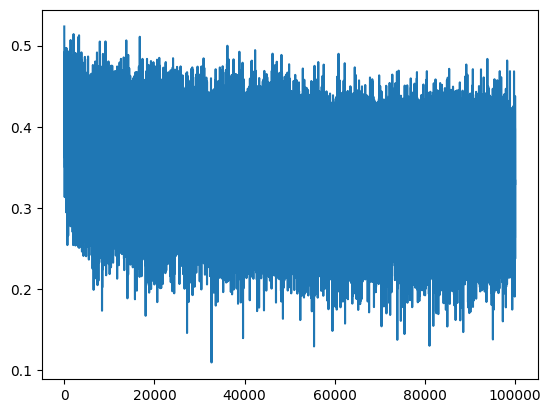

In [64]:
plt.plot(lossi)

In [66]:
#Calibrate batch norm at the end of Training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over entire training set
    bnmeam = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [67]:
bnmeam

tensor([[ 7.4860e-02, -3.1697e-01, -1.4777e+00,  1.5802e-01, -7.3262e-01,
          8.9735e-01,  1.9023e+00,  1.2593e+00,  8.0500e-01,  1.7028e+00,
         -1.6312e+00, -2.1639e+00, -4.2525e-01, -8.8260e-01, -6.8626e-01,
          1.3959e+00,  4.2045e-01, -1.5600e+00, -1.0139e+00,  1.2501e+00,
          1.3112e+00, -6.9404e-01,  5.0992e-01,  3.9745e-01,  8.5376e-01,
          3.0704e-01,  7.9095e-01, -1.2233e+00,  2.6080e-01,  9.1456e-01,
         -1.5105e-01, -1.3201e+00, -7.9279e-01,  1.2253e-01, -8.1485e-01,
         -1.3728e+00, -1.7180e+00, -7.1914e-01,  1.5463e-01, -1.0429e-01,
          4.3155e-01, -4.8529e-01, -1.3578e+00, -2.2507e-01,  1.1651e+00,
          3.3672e-01, -2.7532e-01, -5.1702e-01,  8.6108e-01,  1.5286e+00,
          4.5287e-01,  5.8105e-01,  1.9845e+00,  2.5009e-01,  1.2459e+00,
         -1.6000e+00, -6.1709e-01,  5.9742e-01,  6.7848e-01, -4.4376e-01,
         -9.0939e-01, -3.0308e-02, -6.6839e-01, -5.3268e-01,  2.9641e-01,
          1.2670e-01,  2.6375e-01,  7.

In [68]:
bnmean_running

tensor([[ 7.3727e-02, -3.2469e-01, -1.4775e+00,  1.6083e-01, -7.2662e-01,
          8.9080e-01,  1.9039e+00,  1.2666e+00,  8.1070e-01,  1.7078e+00,
         -1.6412e+00, -2.1674e+00, -4.2985e-01, -8.7516e-01, -6.9785e-01,
          1.3984e+00,  4.2906e-01, -1.5555e+00, -1.0182e+00,  1.2605e+00,
          1.3058e+00, -6.8484e-01,  5.0228e-01,  3.8325e-01,  8.4887e-01,
          3.0533e-01,  7.9635e-01, -1.2271e+00,  2.7678e-01,  9.2923e-01,
         -1.5662e-01, -1.3104e+00, -7.8411e-01,  1.1022e-01, -8.0387e-01,
         -1.3766e+00, -1.6992e+00, -7.1808e-01,  1.3208e-01, -9.6625e-02,
          4.2161e-01, -4.8674e-01, -1.3486e+00, -2.1071e-01,  1.1532e+00,
          3.2484e-01, -2.7955e-01, -5.1323e-01,  8.5482e-01,  1.5189e+00,
          4.5776e-01,  5.6588e-01,  1.9911e+00,  2.6246e-01,  1.2472e+00,
         -1.6079e+00, -6.0931e-01,  6.0387e-01,  6.6495e-01, -4.4639e-01,
         -9.1407e-01, -2.2838e-02, -6.6650e-01, -5.3514e-01,  2.9307e-01,
          1.1213e-01,  2.6743e-01,  7.

In [ ]:
@torch.no_grad()    # this decorator desables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, num_hidden)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batch normalization
    h = torch.tanh(hpreact) #N, n_hidden
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)    
    print(loss.item())

split_loss('train')
split_loss('val')

# ver 2 
# 2.2141671180725098
# 2.262075424194336

#Ver3
# 2.0615365505218506
# 2.1102068424224854

#batch_norm
# 2.0923383235931396
# 2.12758731842041

#bn_running
# @torch.no_grad()    # this decorator desables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, num_hidden)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batch normalization
    h = torch.tanh(hpreact) #N, n_hidden
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)    
    print(loss.item())

split_loss('train')
split_loss('val')

# ver 2 
# 2.2141671180725098
# 2.262075424194336

#Ver3
# 2.0615365505218506
# 2.1102068424224854

#batch_norm
# 2.0923383235931396
# 2.12758731842041

#bn_running
# 2.0923383235931396
# 2.12758731842041



2.092454433441162
2.1278464794158936


In [53]:
#Sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initalizing with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

zrivagmyazzservendhrkklarzthrnghjd.
quzraqhjador.
xuzshppnplrengggvungxarqwptzsorfqharnjshdbvrgdhumiyan.
jadrxjevqhxnbettf.
ubukthdng.
jaqufzeks.
karshveklyzx.
hjandagyansufpzerslvengrnj.
quvwurjaqqzeffrddiffordyn.
hmbptibrrumungynghmrangjud.
qurffevshxwrlanklutzperz.
jadgynzahmaitgf.
xvalfivus.
mburrkefxrdor.
xavonghmuscoenngyannavtuttpfreddih.
vorlqhajadrpxummikgrriqtaviczurgvontet.
jhdnbrbak.
phrygnoghanququzp.
quknyxxcithbrid.
qujthw.
